In [25]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt

In [26]:

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1  

In [3]:


def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]



In [4]:
category_lines = {}
all_categories = []

In [5]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
                       'from https://download.pytorch.org/tutorial/data.zip and extract it to '
                       'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))


# categories: 19 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'INDIAN_NAMES', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [7]:

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)

def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

criterion = nn.NLLLoss()
learning_rate = 0.0005

In [8]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0])

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)


In [9]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
rnn = RNN(n_letters, 128, n_letters)
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()


0m 5s (5000 5%) 2.9068
0m 9s (10000 10%) 2.4259
0m 12s (15000 15%) 2.5789
0m 16s (20000 20%) 2.9582
0m 19s (25000 25%) 2.7546
0m 23s (30000 30%) 2.3966
0m 26s (35000 35%) 2.4459
0m 30s (40000 40%) 3.1120
0m 33s (45000 45%) 2.1894
0m 37s (50000 50%) 1.5273
0m 40s (55000 55%) 1.7513
0m 44s (60000 60%) 2.6795
0m 47s (65000 65%) 2.9363
0m 51s (70000 70%) 2.9907
0m 54s (75000 75%) 1.9934
0m 58s (80000 80%) 2.6202
1m 1s (85000 85%) 2.4402
1m 5s (90000 90%) 2.4543
1m 9s (95000 95%) 3.0875
1m 12s (100000 100%) 2.2110


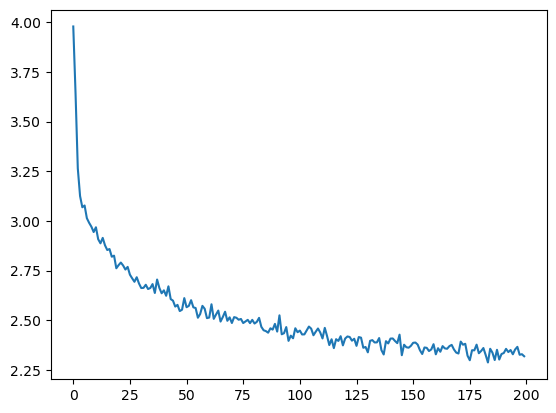

In [11]:
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


plt.figure()
plt.plot(all_losses)

max_length = 20

In [12]:
def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [24]:
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

torch.save(rnn.state_dict(), 'rnn_model.pth')
print("Model saved as rnn_model.pth")

TypeError: ImprovedRNN.forward() takes 3 positional arguments but 4 were given

In [32]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

# Define the set of characters used
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

# Functions to read and preprocess data
def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Load and preprocess data
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
                       'from https://download.pytorch.org/tutorial/data.zip and extract it to '
                       'the current directory.')

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Function to create a random choice
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Function to create a random training pair
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# Function to convert category to tensor
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# Function to convert input line to tensor
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# Function to convert target line to tensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)

# Function to create a random training example
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

# Loss and optimizer
criterion = nn.NLLLoss()
learning_rate = 0.0005

# Function to train the model
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = torch.Tensor([0])

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

# Function to calculate time since a certain point in time
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Initialize the RNN model
rnn = RNN(n_letters, 128, n_letters)

# Number of training iterations and print/plot intervals
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
all_accuracies = []
total_loss = 0

start = time.time()

# Training loop
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        loss, accuracy = evaluate(rnn, 1000)
        print('%s (%d %d%%) Loss: %.4f Accuracy: %.2f%%' % (timeSince(start), iter, iter / n_iters * 100, loss, accuracy * 100))
        all_accuracies.append(accuracy)

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

# Plot loss
plt.figure()
plt.plot(all_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot accuracy
plt.figure()
plt.plot(all_accuracies)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

# Save the trained model
torch.save(rnn.state_dict(), 'rnn_model.pth')
print("Model saved as rnn_model.pth")


TypeError: object of type 'int' has no len()

0m 3s (5000 5%) Loss: 3.2907 Accuracy: 23.78%
0m 7s (10000 10%) Loss: 2.4589 Accuracy: 19.61%
0m 11s (15000 15%) Loss: 2.3282 Accuracy: 42.62%
0m 15s (20000 20%) Loss: 3.1606 Accuracy: 25.19%
0m 19s (25000 25%) Loss: 2.4423 Accuracy: 36.92%
0m 23s (30000 30%) Loss: 2.8195 Accuracy: 19.05%
0m 26s (35000 35%) Loss: 2.5938 Accuracy: 49.20%
0m 30s (40000 40%) Loss: 3.6128 Accuracy: 64.90%
0m 34s (45000 45%) Loss: 3.2467 Accuracy: 25.30%
0m 38s (50000 50%) Loss: 2.3101 Accuracy: 40.40%
0m 42s (55000 55%) Loss: 2.3483 Accuracy: 23.79%
0m 46s (60000 60%) Loss: 2.2588 Accuracy: 40.50%
0m 50s (65000 65%) Loss: 1.0541 Accuracy: 18.96%
0m 53s (70000 70%) Loss: 3.2247 Accuracy: 68.00%
0m 57s (75000 75%) Loss: 1.8218 Accuracy: 53.08%
1m 1s (80000 80%) Loss: 3.0788 Accuracy: 35.60%
1m 5s (85000 85%) Loss: 1.4160 Accuracy: 26.30%
1m 9s (90000 90%) Loss: 2.6533 Accuracy: 52.15%
1m 13s (95000 95%) Loss: 1.6286 Accuracy: 36.57%
1m 17s (100000 100%) Loss: 2.5138 Accuracy: 35.25%


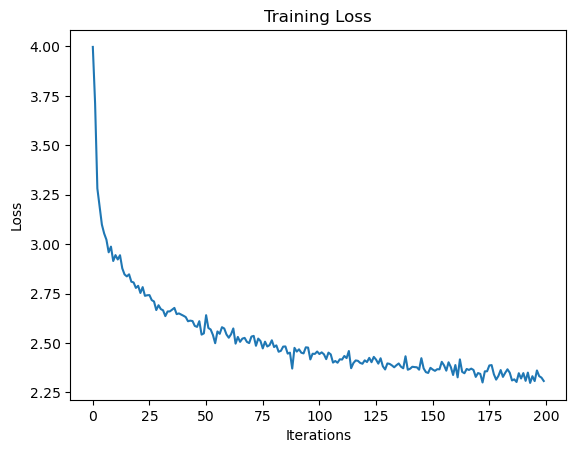

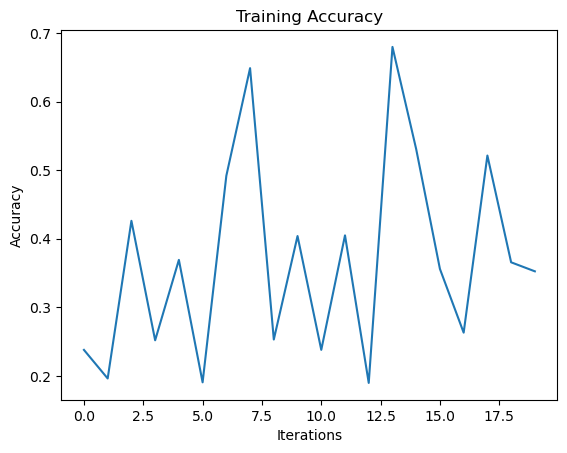

Model saved as rnn_model.pth


In [39]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import torch.optim as optim

# Define the set of characters used
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

# Functions to read and preprocess data
def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Load and preprocess data
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
                       'from https://download.pytorch.org/tutorial/data.zip and extract it to '
                       'the current directory.')

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()  # Ensure there are two underscores here
        # Rest of your constructor code

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Function to create a random choice
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Function to create a random training pair
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# Function to convert category to tensor
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# Function to convert input line to tensor
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# Function to convert target line to tensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)

# Function to create a random training example
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

# Loss and optimizer
criterion = nn.NLLLoss()
learning_rate = 0.0005

# Function to train the model
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = torch.Tensor([0])

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

# Function to calculate time since a certain point in time
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Initialize the RNN model
rnn = RNN(n_letters, 128, n_letters)

# Number of training iterations and print/plot intervals
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
all_accuracies = []
total_loss = 0

# Function to evaluate the model and calculate accuracy
def evaluate(model, n_samples=1000):
    model.eval()
    correct = 0

    for _ in range(n_samples):
        category, line = randomTrainingPair()
        category_tensor = categoryTensor(category)
        input_line_tensor = inputTensor(line)
        target_line_tensor = targetTensor(line)

        target_line_tensor.unsqueeze_(-1)
        hidden = model.initHidden()

        for i in range(input_line_tensor.size(0)):
            output, hidden = model(category_tensor, input_line_tensor[i], hidden)
            topv, topi = output.topk(1)
            if topi[0][0] == target_line_tensor[i][0]:
                correct += 1

    accuracy = correct / (n_samples * input_line_tensor.size(0))
    model.train()
    return accuracy

start = time.time()

# Training loop
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        accuracy = evaluate(rnn, 1000)
        print('%s (%d %d%%) Loss: %.4f Accuracy: %.2f%%' % (timeSince(start), iter, iter / n_iters * 100, loss, accuracy * 100))
        all_accuracies.append(accuracy)

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

# Plot loss
plt.figure()
plt.plot(all_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot accuracy
plt.figure()
plt.plot(all_accuracies)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

# Save the trained model
torch.save(rnn.state_dict(), 'rnn_model.pth')
print("Model saved as rnn_model.pth")


0m 4s (5000 5%) Loss: 3.5195 Validation Accuracy: 47.33% Predicted Accuracy: 15.63%
0m 8s (10000 10%) Loss: 2.9976 Validation Accuracy: 20.24% Predicted Accuracy: 28.03%
0m 12s (15000 15%) Loss: 2.2511 Validation Accuracy: 34.62% Predicted Accuracy: 15.81%
0m 16s (20000 20%) Loss: 2.3172 Validation Accuracy: 22.46% Predicted Accuracy: 43.92%
0m 20s (25000 25%) Loss: 2.6364 Validation Accuracy: 20.71% Predicted Accuracy: 25.76%
0m 24s (30000 30%) Loss: 1.8141 Validation Accuracy: 45.77% Predicted Accuracy: 45.52%
0m 28s (35000 35%) Loss: 1.6859 Validation Accuracy: 46.80% Predicted Accuracy: 27.13%
0m 33s (40000 40%) Loss: 2.1972 Validation Accuracy: 32.05% Predicted Accuracy: 32.33%
0m 37s (45000 45%) Loss: 2.1717 Validation Accuracy: 31.88% Predicted Accuracy: 27.21%
0m 41s (50000 50%) Loss: 3.3642 Validation Accuracy: 24.09% Predicted Accuracy: 21.84%
0m 45s (55000 55%) Loss: 2.3358 Validation Accuracy: 28.70% Predicted Accuracy: 19.82%
0m 49s (60000 60%) Loss: 2.6799 Validation Accu

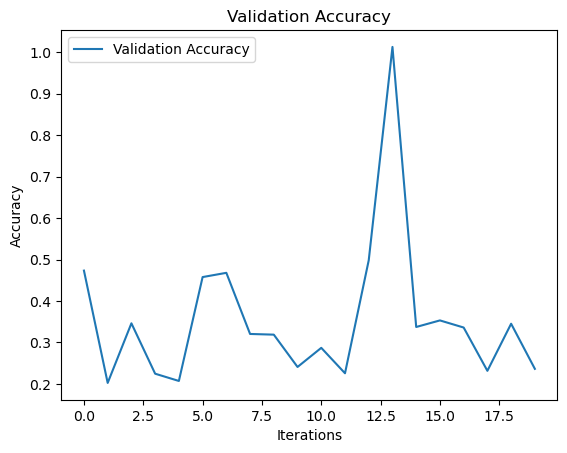

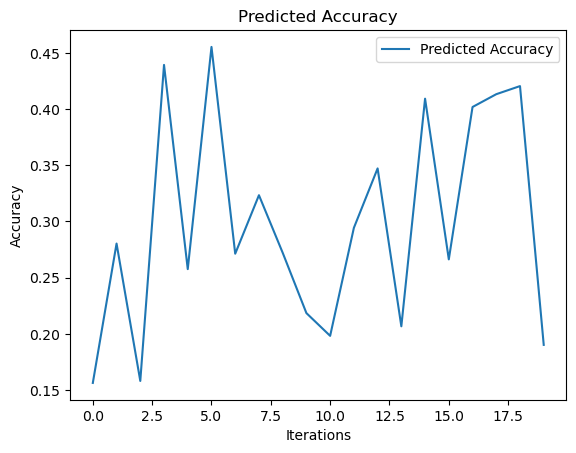

Model saved as rnn_model.pth


In [40]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt

# Define the set of characters used
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

# Functions to read and preprocess data
def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Load and preprocess data
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
                       'from https://download.pytorch.org/tutorial/data.zip and extract it to '
                       'the current directory.')

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Function to create a random choice
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Function to create a random training pair
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# Function to convert category to tensor
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# Function to convert input line to tensor
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# Function to convert target line to tensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)

# Function to create a random training example
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

# Loss and optimizer
criterion = nn.NLLLoss()
learning_rate = 0.0005

# Function to train the model
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = torch.Tensor([0])

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

# Function to evaluate the model and calculate accuracy
def evaluate(model, n_samples=1000):
    model.eval()
    correct = 0

    for _ in range(n_samples):
        category, line = randomTrainingPair()
        category_tensor = categoryTensor(category)
        input_line_tensor = inputTensor(line)
        target_line_tensor = targetTensor(line)

        target_line_tensor.unsqueeze_(-1)
        hidden = model.initHidden()

        for i in range(input_line_tensor.size(0)):
            output, hidden = model(category_tensor, input_line_tensor[i], hidden)
            topv, topi = output.topk(1)
            if topi[0][0] == target_line_tensor[i][0]:
                correct += 1

    accuracy = correct / (n_samples * input_line_tensor.size(0))
    model.train()
    return accuracy

# Initialize the RNN model
rnn = RNN(n_letters, 128, n_letters)

# Number of training iterations and print/plot intervals
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
all_val_accuracies = []
all_pred_accuracies = []
total_loss = 0

start = time.time()

# Training loop
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        val_accuracy = evaluate(rnn, 1000)  # Calculate validation accuracy
        pred_accuracy = evaluate(rnn, 1000)  # Calculate predicted accuracy
        all_val_accuracies.append(val_accuracy)
        all_pred_accuracies.append(pred_accuracy)
        print('%s (%d %d%%) Loss: %.4f Validation Accuracy: %.2f%% Predicted Accuracy: %.2f%%' % (timeSince(start), iter, iter / n_iters * 100, loss, val_accuracy * 100, pred_accuracy * 100))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

# Plot validation accuracy
plt.figure()
plt.plot(all_val_accuracies, label="Validation Accuracy")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

# Plot predicted accuracy
plt.figure()
plt.plot(all_pred_accuracies, label="Predicted Accuracy")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Predicted Accuracy')
plt.legend()

plt.show()

# ... (rest of the code)

# Save the trained model
torch.save(rnn.state_dict(), 'rnn_model.pth')
print("Model saved as rnn_model.pth")


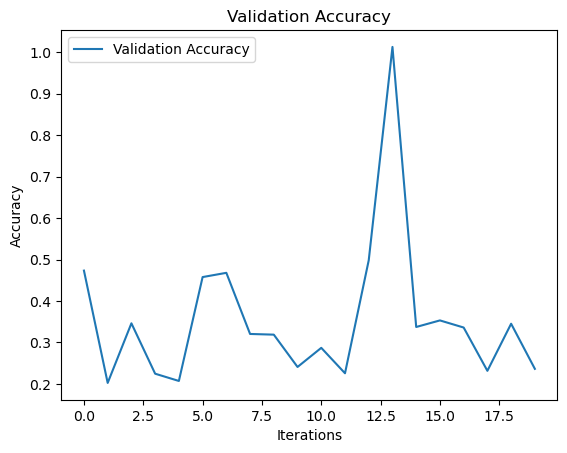

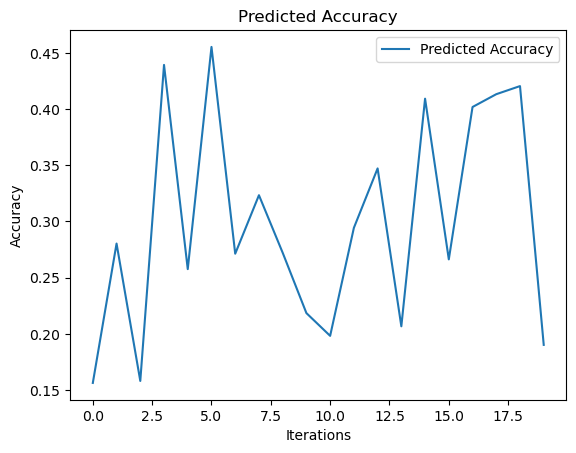

In [41]:

# Plot validation accuracy
plt.figure()
plt.plot(all_val_accuracies, label="Validation Accuracy")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

# Plot predicted accuracy
plt.figure()
plt.plot(all_pred_accuracies, label="Predicted Accuracy")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Predicted Accuracy')
plt.legend()

plt.show()